# TextbookQA App

This demo will create a QA system for the example textbooks, [Health Science](https://drive.google.com/file/d/1hOf6wPNjeUvWflVIRwjbB7h-qMTMMp-G/view) or [Intro to Nutrition](https://www.oercommons.org/courses/an-introduction-to-nutrition-v1-0/view). Relevant resources can be found in the examples directory.

## Part 1: Setting up the Model

In [1]:
#export
import os

In [2]:
os.chdir("../")

In [3]:
#export
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, PretrainedConfig
import sqlite3, os, pandas as pd
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import save_npz, load_npz
import pickle
from pathlib import Path
from src import AlbertForQuestionAnsweringMTL, Config
from src.utils_app import get_pred, get_contexts, get_scores
import requests
import pandas as pd

In [4]:
# export
config = Config(
    model = "albert-base-v2",
    weights = "models/2.0/base",
    pad_idx = 0,
    example = "intro_to_nutrition",
    book_name = "Intro to Nutrition",
    book_link = "https://drive.google.com/file/d/1hOf6wPNjeUvWflVIRwjbB7h-qMTMMp-G/view",
    sections_file_type = "csv" # can be either db or csv
)

In [5]:
#export
tok = AutoTokenizer.from_pretrained(config.model)
model = AlbertForQuestionAnsweringMTL.from_pretrained(config.weights) # ensure pytroch_model.bin and config files are saved in directory

In [29]:
#export
if config.sections_file_type == "db":
    # connecting to the DB
    con = sqlite3.connect(f'examples/{config.example}/sections.{config.sections_file_type}')
    data = con.cursor()
elif config.sections_file_type == "csv":
    data = pd.read_csv(f'examples/{config.example}/sections.{config.sections_file_type}')

## TF-IDF Embeddings

In [30]:
#export
# loading files
X = load_npz(f"examples/{config.example}/tfidf-vectors.npz")
vectorizer = pickle.load(open(f"examples/{config.example}/vectorizer.pkl","rb"))

## Making Predictions

# Application

In [31]:
#export
import panel as pn
css = """ """ # use for custom css
pn.extension(raw_css=[css])

In [32]:
#export
# creating the text input widget
question = pn.widgets.TextInput(placeholder="input a health science related query here")

In [33]:
#export
question

TextInput(placeholder='input a health s...)

In [34]:
#export
# creating the markdown text pane where generated text will go
answer = pn.pane.Markdown("")
section = pn.pane.Markdown("",width=600,background="yellow")
section_spacer = pn.pane.Markdown("**Most Relevant Section:**")

In [35]:
# previewing the contents of both and observing how one changes the other (have to press enter after inputting text)
pn.Column(question, answer,section)

Column
    [0] TextInput(placeholder='input a health s...)
    [1] Markdown(str)
    [2] Markdown(str, background='yellow', width=600)

In [36]:
#export
# create the button widget
button = pn.widgets.Button(name="Submit",button_type="warning")

In [37]:
button

Button(button_type='warning', name='Submit')

In [38]:
#export
# writing the call back function when the generate_button is clicked
def click_cb(event):
    button.name, button.button_type = "Finding Answer...", "success" # change button to represent processing
    scores = get_scores(question.value, vectorizer, X)
    contexts = get_contexts(scores, data)
    pred, best_section = get_pred(contexts, question.value, model, tok, config.pad_idx)
    section.object = best_section
    answer.object = pred
    button.name, button.button_type = "Submit", "warning" # change button back

In [39]:
q = "what is FDA?"
scores = get_scores(q, vectorizer, X)
contexts = get_contexts(scores, df)
pred = get_pred(contexts,q, model, tok, config.pad_idx)
pred

('dietary supplements must meet the fda<unk>s good manufacturing standards',
 'The Food and Drug Administration (FDA) regulates supplements, but it treats them like food rather than pharmaceuticals. Dietary supplements must meet  the FDA’s Good Manufacturing Standards, but are not required to meet the standards for drugs, although some companies do so voluntarily. Also, although supplement manufacturers are allowed to say a particular ingredient may reduce the risk of a disease or disorder, or that it might specifically target certain body systems, these claims are not approved by the FDA. This is why labels that make structural and functional claims are required to carry a disclaimer saying the product is not intended “to diagnose, treat, cure, or prevent any disease.” In addition, in the United States, supplements are taken off the market only after the FDA has proven that they are hazardous.Watson, S. “How to Evaluate Vitamins and Supplements.” Web MD. Accessed December 21, 2011. ht

In [40]:
#export
# linking the on_click acton with the click_cb function
button.on_click(click_cb)

In [41]:
#export
# compiling our app with the objects we have created thus far
app = pn.Column(pn.Column(question,button,answer,section_spacer,section))

In [42]:
app

Column
    [0] Column
        [0] TextInput(placeholder='input a health s...)
        [1] Button(button_type='warning', name='Submit')
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Markdown(str, background='yellow', width=600)

In [60]:
#export
# Building the final app with a title, description, images etc.
title_style = {"font-family":"impact"}
style = {"font-family":""}
title = pn.pane.Markdown("# **askAi**",style=title_style)
desc = pn.pane.Markdown(f"Welcome to **TextBookQA**, a question answering demo for extracting answers from \
textbooks. This demo is based on the textbook, [*{config.book_name}*]({config.book_link}) \
(source: openbooks). Input a respective question and receive the answer and the relevant section.",style=style)
img1 = pn.pane.PNG(f"examples/{config.example}/cover.png",height=300,align="center")
footer = pn.pane.HTML("""<a href="https://github.com/devkosal/albert-qa">Github""", align="center")
# Panel spacer object to center our title
h_spacer = pn.layout.HSpacer()
final_app = pn.Row(h_spacer, pn.Column( pn.Row(h_spacer,title,h_spacer) , desc, img1 ,app, footer), h_spacer)

Row
    [0] HSpacer()
    [1] Column
        [0] Row
            [0] HSpacer()
            [1] Markdown(str, style={'font-family': 'impact'})
            [2] HSpacer()
        [1] Markdown(str, style={'font-family': ''})
        [2] PNG(str, align='center', height=300)
        [3] Column
            [0] Column
                [0] TextInput(placeholder='input a health s..., value='is drinking healthy? ')
                [1] Button(button_type='warning', clicks=8, name='Submit')
                [2] Markdown(str)
                [3] Markdown(str)
                [4] Markdown(str, background='yellow', width=600)
        [4] HTML(str, align='center')
    [2] HSpacer()
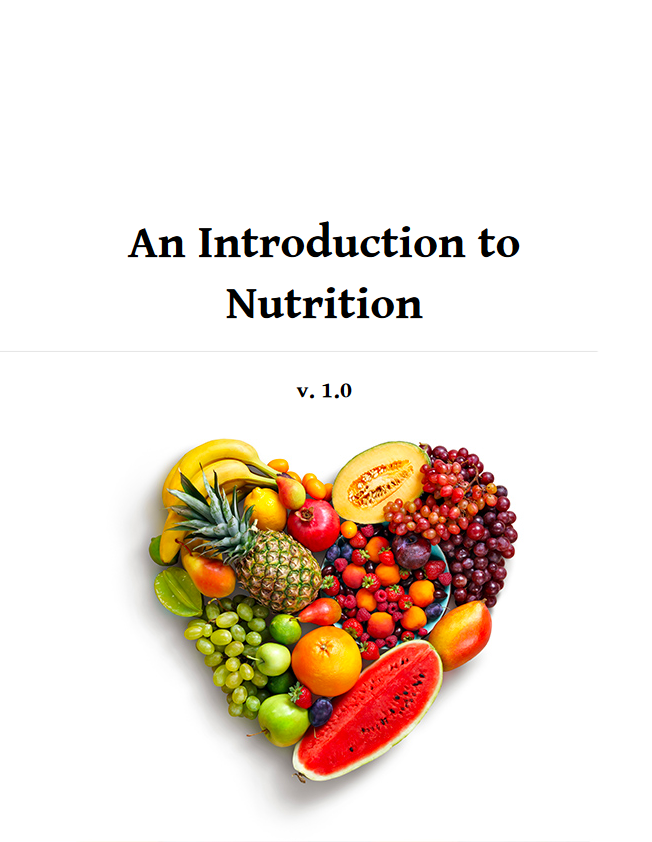

In [61]:
final_app

In [45]:
# this command will launch the final app in a new tab (for debugging purposes)
final_app.show()

Row
    [0] HSpacer()
    [1] Column
        [0] Row
            [0] HSpacer()
            [1] Markdown(str, style={'font-family': 'impact'})
            [2] HSpacer()
        [1] Markdown(str, style={'font-family': ''})
        [2] PNG(str, align='center', height=300)
        [3] Column
            [0] Column
                [0] TextInput(placeholder='input a health s...)
                [1] Button(button_type='warning', name='Submit')
                [2] Markdown(str)
                [3] Markdown(str)
                [4] Markdown(str, background='yellow', width=600)
        [4] HTML(str, align='center')
    [2] HSpacer()
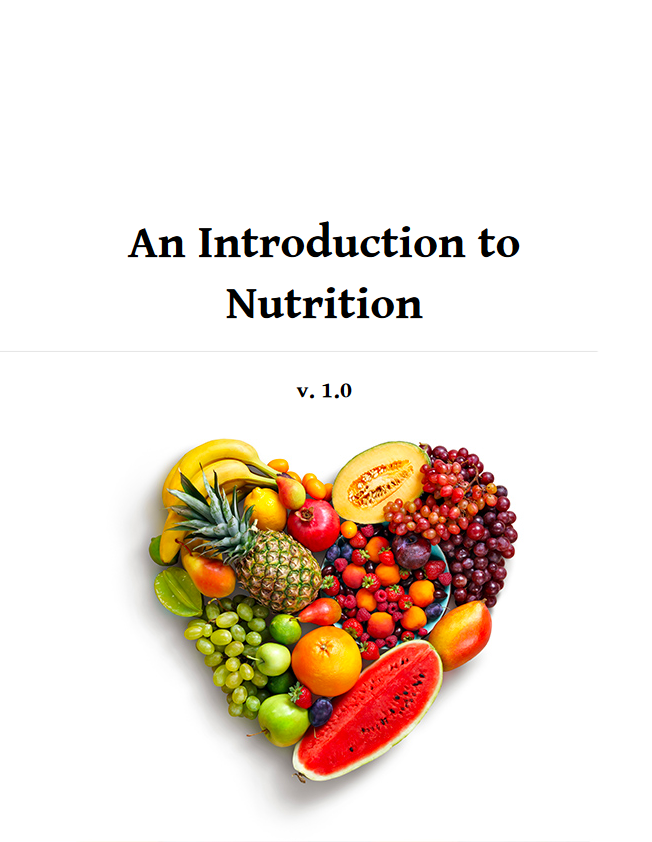

In [26]:
#export
# this command is needed in order to serve this app in production mode. (make sure to uncomment ofcourse)
final_app.servable()

In [27]:
# bash command to serve this app in a production setting
# ! panel serve --show "TextbookQA_App.ipynb"